# Per-pathway connection probability model building of the whole SSCx circuit
## Preparation of neuron tables and adjacency matrices per pathway

In [1]:
# Global imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sps
import os
import sys
import logging
import pickle
import progressbar

# Local imports
sys.path.append('../../library')
import modelling

In [2]:
save_path = './modelling'
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Mid-range connectivity

In [45]:
data_path = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices'
conn_fn = 'intra_SSCX_midrange_wm.npz'
nrn_fn = 'neuron_info_extended.feather'
conn_type = 'midrange'

In [3]:
# Load connectivity matrix and neuron table
adj_matrix = sps.load_npz(os.path.join(data_path, conn_fn))
nrn_table = pd.read_feather(os.path.join(data_path, nrn_fn))
assert adj_matrix.shape[0] == adj_matrix.shape[1] == nrn_table.shape[0], 'ERROR: Data size mismatch!'
print(f'INFO: Loaded connectivity and properties of {nrn_table.shape[0]} neurons')

INFO: Loaded connectivity and properties of 4234929 neurons


In [106]:
# Extract neuron tables per m-type
nrn_path = os.path.join(save_path, 'nrn_tables', conn_type)
if not os.path.exists(nrn_path):
    os.makedirs(nrn_path)

mtypes = np.unique(nrn_table['mtype'])
print(f'Found {len(mtypes)} m-types: {mtypes[0]}, ..., {mtypes[-1]}', flush=True)
np.save(os.path.join(nrn_path, 'mtypes.npy'), mtypes.astype(str))

pbar = progressbar.ProgressBar()
for idx in pbar(range(len(mtypes))):
    nrn_table_sel = nrn_table[nrn_table['mtype'] == mtypes[idx]]
    nrn_table_sel.reset_index().to_feather(os.path.join(nrn_path, f'nrn_info__{mtypes[idx]}.feather'))


Found 60 m-types: L1_DAC, ..., L6_UPC


100% |########################################################################|


In [61]:
# Extract sub-matrices per pathway (PRE m-types x POST m-types)
mat_path = os.path.join(save_path, 'adj_matrices', conn_type)
if not os.path.exists(mat_path):
    os.makedirs(mat_path)

adj_sizes = np.full((len(mtypes), len(mtypes), 2), -1)
conn_counts = np.full((len(mtypes), len(mtypes)), -1)

pbar = progressbar.ProgressBar()
for src_idx in pbar(range(len(mtypes))):
    nrn_sel_src = nrn_table[nrn_table['mtype'] == mtypes[src_idx]].index
    for tgt_idx in range(len(mtypes)):
        nrn_sel_tgt = nrn_table[nrn_table['mtype'] == mtypes[tgt_idx]].index
        adj_matrix_pathway = adj_matrix[nrn_sel_src, :][:, nrn_sel_tgt]

        adj_sizes[src_idx, tgt_idx, :] = adj_matrix_pathway.shape
        conn_counts[src_idx, tgt_idx] = adj_matrix_pathway.count_nonzero()

        sps.save_npz(os.path.join(mat_path, f'adj_mat__{mtypes[src_idx]}-{mtypes[tgt_idx]}'), adj_matrix_pathway)

np.save(os.path.join(mat_path, 'adj_sizes.npy'), adj_sizes)
np.save(os.path.join(mat_path, 'conn_counts.npy'), conn_counts)

Found 60 m-types: L1_DAC, ..., L6_UPC


100% |########################################################################|


In [79]:
# Check counts
assert np.sum(conn_counts == -1) == 0, 'ERROR: Connection counts missing!'
assert np.sum(adj_sizes == -1) == 0, 'ERROR: Matrix sizes missing!'
assert np.sum(conn_counts) == adj_matrix.count_nonzero(), 'ERROR: Connection count mismatch!'
assert np.sum(np.prod(adj_sizes, 2)) == np.prod(adj_matrix.shape), 'ERROR: Matrix size mismatch!'
print('INFO: Counts OK!')

INFO: Counts OK!


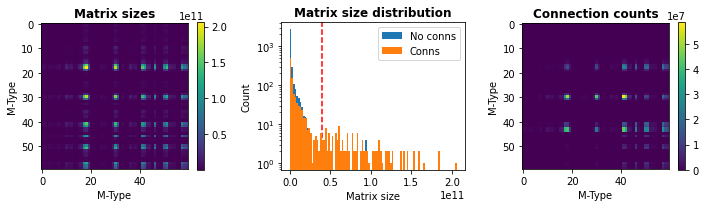

In [213]:
# Show matrix sizes and connection counts
size_lim = 200000**2 # Size limit tested successfully
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(np.prod(adj_sizes, 2), interpolation='nearest')
plt.xlabel('M-Type')
plt.ylabel('M-Type')
plt.title('Matrix sizes', fontweight='bold')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.hist(np.prod(adj_sizes, 2).flatten(), bins=100, log=True, label='No conns')
plt.hist(np.prod(adj_sizes, 2)[conn_counts > 0].flatten(), bins=100, log=True, label='Conns')
# size_hist = np.histogram(np.prod(adj_sizes, 2), bins=100)
# step_size = np.min(np.diff(size_hist[1]))
# # plt.plot(size_hist[1][1:] - step_size, size_hist[0])
# plt.plot(size_hist[1][1:] - step_size, np.cumsum(size_hist[0]))
plt.ylim(plt.ylim()) # Freeze limit
plt.plot([size_lim] * 2, plt.ylim(), '--r', zorder=0)
plt.xlabel('Matrix size')
plt.ylabel('Count')
plt.title('Matrix size distribution', fontweight='bold')
plt.legend()
plt.subplot(1, 3, 3)
plt.imshow(conn_counts, interpolation='nearest')
plt.xlabel('M-Type')
plt.ylabel('M-Type')
plt.title('Connection counts', fontweight='bold')
plt.colorbar()
plt.tight_layout()
plt.show()

In [221]:
max_idx = np.unravel_index(np.argmax(np.prod(adj_sizes, 2)), adj_sizes.shape[:2])
print(f'Max. size: {mtypes[max_idx[0]]}-{mtypes[max_idx[1]]}: {adj_sizes[max_idx[0], max_idx[1], 0]}x{adj_sizes[max_idx[0], max_idx[1], 1]} = {np.prod(adj_sizes[max_idx[0], max_idx[1], :])}')

max_idx = np.unravel_index(np.argmax(conn_counts), adj_sizes.shape[:2])
print(f'Max. conn. count: {mtypes[max_idx[0]]}-{mtypes[max_idx[1]]}: {conn_counts[max_idx[0], max_idx[1]]}')

print(f'Pathways w/o connections: {np.sum(conn_counts == 0)} of {np.sum(conn_counts >= 0)} ({100 * np.sum(conn_counts == 0) / np.sum(conn_counts >= 0)}%)')

Max. size: L3_TPC:A-L3_TPC:A: 453858x453858 = 205987084164
Max. conn. count: L4_TPC-L5_TPC:A: 58568344
Pathways w/o connections: 2520 of 3600 (70.0%)


In [224]:
# Extract sub-matrices per pathway (PRE m-types x All POST)
mat_path = os.path.join(save_path, 'adj_matrices', conn_type)
if not os.path.exists(mat_path):
    os.makedirs(mat_path)

adj_sizes = np.full((len(mtypes), 2), -1)
conn_counts = np.full(len(mtypes), -1)

pbar = progressbar.ProgressBar()
for src_idx in pbar(range(len(mtypes))):
    nrn_sel_src = nrn_table[nrn_table['mtype'] == mtypes[src_idx]].index
    adj_matrix_pathway = adj_matrix[nrn_sel_src, :]

    adj_sizes[src_idx, :] = adj_matrix_pathway.shape
    conn_counts[src_idx] = adj_matrix_pathway.count_nonzero()

    sps.save_npz(os.path.join(mat_path, f'adj_mat__{mtypes[src_idx]}-ALL'), adj_matrix_pathway)

np.save(os.path.join(mat_path, 'adj_sizes_PRE.npy'), adj_sizes)
np.save(os.path.join(mat_path, 'conn_counts_PRE.npy'), conn_counts)

100% |########################################################################|


In [227]:
max_idx = np.argmax(np.prod(adj_sizes, 1))
print(f'Max. size: {mtypes[max_idx]}-ALL: {adj_sizes[max_idx, 0]}x{adj_sizes[max_idx, 1]} = {np.prod(adj_sizes[max_idx, :])}')

max_idx = np.argmax(conn_counts)
print(f'Max. conn. count: {mtypes[max_idx]}-ALL: {conn_counts[max_idx]}')

print(f'Pathways w/o connections: {np.sum(conn_counts == 0)} of {np.sum(conn_counts >= 0)} ({100 * np.sum(conn_counts == 0) / np.sum(conn_counts >= 0)}%)')

Max. size: L3_TPC:A-ALL: 453858x4234929 = 1922056406082
Max. conn. count: L4_TPC-ALL: 385285691
Pathways w/o connections: 42 of 60 (70.0%)


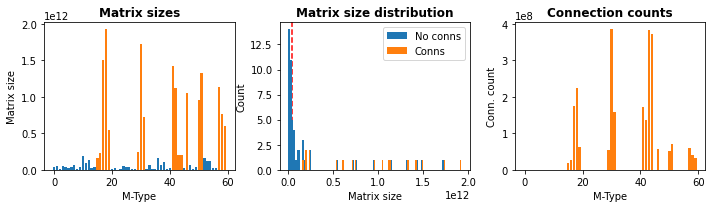

In [229]:
# Show matrix sizes and connection counts
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.bar(np.arange(len(mtypes)), np.prod(adj_sizes, 1), label='No conns')
plt.bar(np.arange(len(mtypes))[conn_counts > 0], np.prod(adj_sizes, 1)[conn_counts > 0], label='Conns')
plt.xlabel('M-Type')
plt.ylabel('Matrix size')
plt.title('Matrix sizes', fontweight='bold')
plt.subplot(1, 3, 2)
plt.hist(np.prod(adj_sizes, 1), bins=100, log=False, label='No conns')
plt.hist(np.prod(adj_sizes, 1)[conn_counts > 0], bins=100, log=False, label='Conns')
plt.ylim(plt.ylim()) # Freeze limit
plt.plot([size_lim] * 2, plt.ylim(), '--r', zorder=0)
plt.xlabel('Matrix size')
plt.ylabel('Count')
plt.title('Matrix size distribution', fontweight='bold')
plt.legend()
plt.subplot(1, 3, 3)
plt.bar(np.arange(len(mtypes)), conn_counts)
plt.bar(np.arange(len(mtypes)), conn_counts)
plt.xlabel('M-Type')
plt.ylabel('Conn. count')
plt.title('Connection counts', fontweight='bold')
plt.tight_layout()
plt.show()

### Local connectivity

In [2]:
data_path = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices'
conn_fn = 'local_connectivity.npz'
nrn_fn = 'neuron_info.feather'
conn_type = 'local'

In [4]:
# Load connectivity matrix and neuron table
adj_matrix = sps.load_npz(os.path.join(data_path, conn_fn))
nrn_table = pd.read_feather(os.path.join(data_path, nrn_fn))
assert adj_matrix.shape[0] == adj_matrix.shape[1] == nrn_table.shape[0], 'ERROR: Data size mismatch!'
print(f'INFO: Loaded connectivity and properties of {nrn_table.shape[0]} neurons')

INFO: Loaded connectivity and properties of 4234929 neurons


In [6]:
# Extract neuron tables per m-type
nrn_path = os.path.join(save_path, 'nrn_tables', conn_type)
if not os.path.exists(nrn_path):
    os.makedirs(nrn_path)

mtypes = np.unique(nrn_table['mtype'])
print(f'Found {len(mtypes)} m-types: {mtypes[0]}, ..., {mtypes[-1]}', flush=True)
np.save(os.path.join(nrn_path, 'mtypes.npy'), mtypes.astype(str))

pbar = progressbar.ProgressBar()
for idx in pbar(range(len(mtypes))):
    nrn_table_sel = nrn_table[nrn_table['mtype'] == mtypes[idx]]
    nrn_table_sel.reset_index().to_feather(os.path.join(nrn_path, f'nrn_info__{mtypes[idx]}.feather'))

Found 60 m-types: L1_DAC, ..., L6_UPC


100% |########################################################################|


In [7]:
# Extract sub-matrices per pathway (PRE m-types x All POST)
mat_path = os.path.join(save_path, 'adj_matrices', conn_type)
if not os.path.exists(mat_path):
    os.makedirs(mat_path)

adj_sizes = np.full((len(mtypes), 2), -1)
conn_counts = np.full(len(mtypes), -1)

pbar = progressbar.ProgressBar()
for src_idx in pbar(range(len(mtypes))):
    nrn_sel_src = nrn_table[nrn_table['mtype'] == mtypes[src_idx]].index
    adj_matrix_pathway = adj_matrix[nrn_sel_src, :]

    adj_sizes[src_idx, :] = adj_matrix_pathway.shape
    conn_counts[src_idx] = adj_matrix_pathway.count_nonzero()

    sps.save_npz(os.path.join(mat_path, f'adj_mat__{mtypes[src_idx]}-ALL'), adj_matrix_pathway)

np.save(os.path.join(mat_path, 'adj_sizes_PRE.npy'), adj_sizes)
np.save(os.path.join(mat_path, 'conn_counts_PRE.npy'), conn_counts)

100% |########################################################################|


In [8]:
max_idx = np.argmax(np.prod(adj_sizes, 1))
print(f'Max. size: {mtypes[max_idx]}-ALL: {adj_sizes[max_idx, 0]}x{adj_sizes[max_idx, 1]} = {np.prod(adj_sizes[max_idx, :])}')

max_idx = np.argmax(conn_counts)
print(f'Max. conn. count: {mtypes[max_idx]}-ALL: {conn_counts[max_idx]}')

print(f'Pathways w/o connections: {np.sum(conn_counts == 0)} of {np.sum(conn_counts >= 0)} ({100 * np.sum(conn_counts == 0) / np.sum(conn_counts >= 0)}%)')

Max. size: L3_TPC:A-ALL: 453858x4234929 = 1922056406082
Max. conn. count: L3_TPC:A-ALL: 291308690
Pathways w/o connections: 0 of 60 (0.0%)


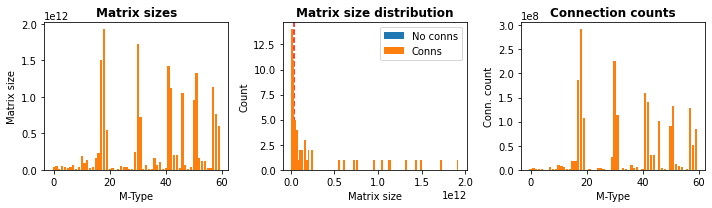

In [10]:
# Show matrix sizes and connection counts
size_lim = 200000**2 # Size limit tested successfully
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.bar(np.arange(len(mtypes)), np.prod(adj_sizes, 1), label='No conns')
plt.bar(np.arange(len(mtypes))[conn_counts > 0], np.prod(adj_sizes, 1)[conn_counts > 0], label='Conns')
plt.xlabel('M-Type')
plt.ylabel('Matrix size')
plt.title('Matrix sizes', fontweight='bold')
plt.subplot(1, 3, 2)
plt.hist(np.prod(adj_sizes, 1), bins=100, log=False, label='No conns')
plt.hist(np.prod(adj_sizes, 1)[conn_counts > 0], bins=100, log=False, label='Conns')
plt.ylim(plt.ylim()) # Freeze limit
plt.plot([size_lim] * 2, plt.ylim(), '--r', zorder=0)
plt.xlabel('Matrix size')
plt.ylabel('Count')
plt.title('Matrix size distribution', fontweight='bold')
plt.legend()
plt.subplot(1, 3, 3)
plt.bar(np.arange(len(mtypes)), conn_counts)
plt.bar(np.arange(len(mtypes)), conn_counts)
plt.xlabel('M-Type')
plt.ylabel('Conn. count')
plt.title('Connection counts', fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
assert False, 'STOP HERE'

## Running model extraction per pathway

Running batch scripts:
- <code>sbatch run_SSCx_model_building_order2_local_per_pathway.sh SAMPLE_SIZE \<MTYPE_IDX_START\> \<MTYPE_IDX_END\><\code>
- <code>sbatch run_SSCx_model_building_order2_midrange_per_pathway.sh SAMPLE_SIZE \<MTYPE_IDX_START\> \<MTYPE_IDX_END\><\code>

## Collecting model coefficient per pathway

In [3]:
model_path = './modelling/tables_per_pathway_100000'
model_fn = 'SSCx_model_params_order-2' # Base filename

In [4]:
def collect_model_coefficients(model_path, model_fn, conn_type, mtypes, coef_names):
    """Load model coefficient tables per pathway, and saves them as summary table."""
    coef_tables = [pd.DataFrame([], index=pd.Index([], name='mtype'), columns=['mean', 'std', 'rSEM', 'N']) for n in coef_names]
    for mt in mtypes:
        model_params = pd.read_hdf(os.path.join(model_path, f'{model_fn}_{conn_type}__{mt}-ALL.h5'))
        for cidx, cname in enumerate(coef_names):
            mean = model_params[cname].mean()
            std = model_params[cname].std()
            rsem = 100.0 * model_params[cname].sem() / model_params[cname].mean() # (in %)
            count = len(model_params[cname])
            coef_tables[cidx] = coef_tables[cidx].append(pd.DataFrame({'mean': mean, 'std': std, 'rSEM': rsem, 'N': count}, index=[mt]))

    # Save summary tables & mean coefficients
    for cidx, cname in enumerate(coef_names):
        coef_tables[cidx].to_hdf(os.path.join(model_path, f'{model_fn}_{conn_type}__{cname}.h5'), key=cname, mode='w')
        coef_tables[cidx].to_csv(os.path.join(model_path, f'{model_fn}_{conn_type}__{cname}.csv'), mode='w')
        np.save(os.path.join(model_path, f'{model_fn}_{conn_type}__{cname}.npy'), coef_tables[cidx]['mean'].to_numpy())

    return coef_tables


def plot_model_coefs_per_pathway(conn_type, coef_names, coef_tables, mtypes):
    """Plots model coefficients per pathway."""
    for cidx, cname in enumerate(coef_names):
        plt.figure(figsize=(12, 4))
        plt.subplot(2, 1, 1)
        plt.bar(range(len(mtypes)), coef_tables[cidx]['mean'].to_numpy())
        plt.xticks(range(len(mtypes)), [])
        plt.xlim([-1, len(mtypes)])
        m = coef_tables[cidx]['mean'][coef_tables[cidx]['mean'] > 0].mean() # [Excluding empty pathways]
        s = coef_tables[cidx]['mean'][coef_tables[cidx]['mean'] > 0].std() # [Excluding empty pathways]
        plt.plot(plt.xlim(), [m] * 2, '--k', label=f'Mean={m:.6f} +/- {s:.6f} (SD)')
        plt.title(cname, fontweight='bold')
        plt.ylabel('Mean')
        plt.grid()
        plt.gca().set_axisbelow(True)
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.bar(range(len(mtypes)), coef_tables[cidx]['rSEM'].to_numpy())
        plt.xticks(range(len(mtypes)), mtypes, rotation=45, ha='right')
        plt.xlim([-1, len(mtypes)])
        m = coef_tables[cidx]['rSEM'][coef_tables[cidx]['mean'] > 0].mean() # [Excluding empty pathways]
        s = coef_tables[cidx]['rSEM'][coef_tables[cidx]['mean'] > 0].std() # [Excluding empty pathways]
        plt.plot(plt.xlim(), [m] * 2, '--k', label=f'Mean={m:.6f} +/- {s:.6f} (SD)')
        plt.ylabel('rSEM (%)')
        plt.grid()
        plt.gca().set_axisbelow(True)
        plt.legend()
        plt.suptitle(f'{conn_type.upper()} connectivity', fontweight='bold')
        plt.tight_layout()
        plt.show()

### Local connectivity

In [6]:
# Load LOCAL model coefficient tables per pathway
conn_type = 'local'
mtypes = np.load(os.path.join('./modelling/nrn_tables', conn_type, 'mtypes.npy'))
coef_names = ['exp_model_scale', 'exp_model_exponent']
coef_tables = collect_model_coefficients(model_path, model_fn, conn_type, mtypes, coef_names)

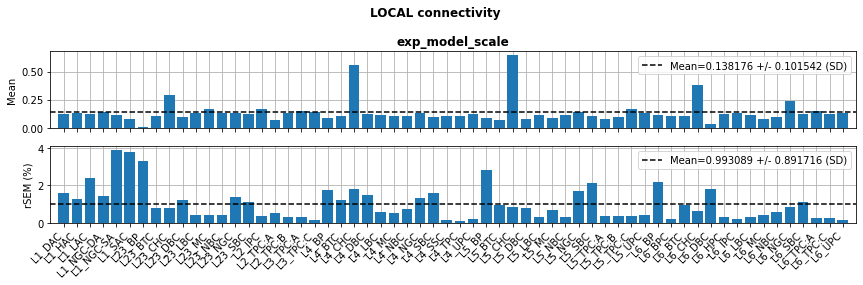

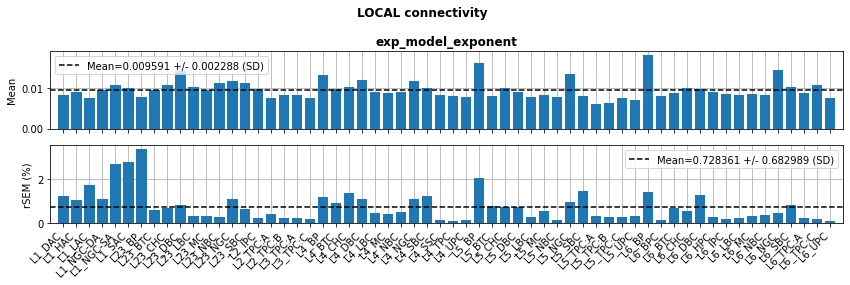

In [7]:
# Plot coefficients
plot_model_coefs_per_pathway(conn_type, coef_names, coef_tables, mtypes)

### Midrange connectivity

In [9]:
# Load LOCAL model coefficient tables per pathway
conn_type = 'midrange'
mtypes = np.load(os.path.join('./modelling/nrn_tables', conn_type, 'mtypes.npy'))
coef_names = ['exp_model_scale', 'exp_model_exponent']
coef_tables = collect_model_coefficients(model_path, model_fn, conn_type, mtypes, coef_names)

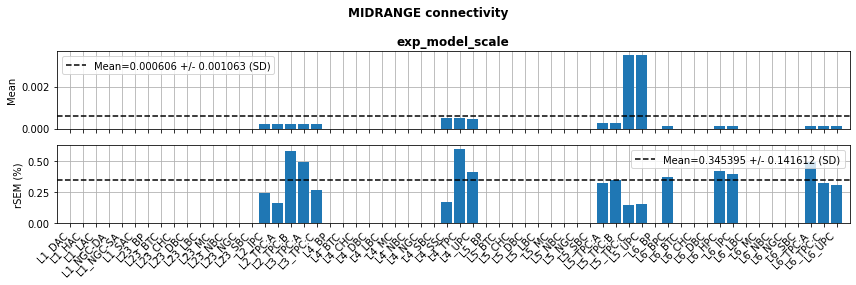

In [ ]:
# Plot coefficients
plot_model_coefs_per_pathway(conn_type, coef_names, coef_tables, mtypes)

## Comparison with randomized control matrix

### Midrange connectivity

In [23]:
# Load midrange connectivity
k = 4 # k between 1-10
ind_file = f'/gpfs/bbp.cscs.ch/data/scratch/proj102/matrices/controls/midrange_dist_dep_block_{k}_indices.npy'
ptr_file = f'/gpfs/bbp.cscs.ch/data/scratch/proj102/matrices/controls/midrange_dist_dep_block_{k}_indptr.npy'
ind_data = np.load(ind_file)
ptr_data = np.load(ptr_file)
adj_matrix = sps.csr_matrix((np.ones_like(ind_data), ind_data, ptr_data), dtype=bool)
nrn_file = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices/neuron_info_extended.feather'
nrn_table = pd.read_feather(nrn_file)
assert adj_matrix.shape[0] == adj_matrix.shape[1] == nrn_table.shape[0], 'ERROR: Data size mismatch!'
print(f'INFO: Loaded connectivity and properties of {nrn_table.shape[0]} neurons')

INFO: Loaded connectivity and properties of 4234929 neurons


In [24]:
# Extract validation model coefficients
# config_dict = {'model_name': 'ValidationMidrange', 'model_order': 2, 'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 1234, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'do_plot': False}
config_dict = {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seeds': [1234], 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}

coefs_validation = np.full((len(mtypes), len(coef_names)), np.nan)
for midx_pre, mt_pre in enumerate(mtypes):
    print(f'>>>>>M-TYPE {midx_pre + 1} of {len(mtypes)} ({mt_pre})<<<<<')

    # Extracxt PRE neuron table
    nrn_sel_pre = nrn_table[nrn_table['mtype'] == mt_pre].index
    nrn_table_pre = nrn_table.loc[nrn_sel_pre]

    # Extract PRE x ALL adj. matrix
    adj_matrix_pathway = adj_matrix[nrn_sel_pre, :]

    # Build model
    if adj_matrix_pathway.count_nonzero() > 0:
        model_params_2 = modelling.conn_prob_2nd_order_pathway_model(adj_matrix_pathway, nrn_table_pre, nrn_table, **config_dict)
        coefs_validation[midx_pre, :] = model_params_2[coef_names].mean(0)

>>>>>M-TYPE 1 of 60 (L1_DAC)<<<<<
>>>>>M-TYPE 2 of 60 (L1_HAC)<<<<<
>>>>>M-TYPE 3 of 60 (L1_LAC)<<<<<
>>>>>M-TYPE 4 of 60 (L1_NGC-DA)<<<<<
>>>>>M-TYPE 5 of 60 (L1_NGC-SA)<<<<<
>>>>>M-TYPE 6 of 60 (L1_SAC)<<<<<
>>>>>M-TYPE 7 of 60 (L23_BP)<<<<<
>>>>>M-TYPE 8 of 60 (L23_BTC)<<<<<
>>>>>M-TYPE 9 of 60 (L23_CHC)<<<<<
>>>>>M-TYPE 10 of 60 (L23_DBC)<<<<<
>>>>>M-TYPE 11 of 60 (L23_LBC)<<<<<
>>>>>M-TYPE 12 of 60 (L23_MC)<<<<<
>>>>>M-TYPE 13 of 60 (L23_NBC)<<<<<
>>>>>M-TYPE 14 of 60 (L23_NGC)<<<<<
>>>>>M-TYPE 15 of 60 (L23_SBC)<<<<<
>>>>>M-TYPE 16 of 60 (L2_IPC)<<<<<
[2022-05-06 17:40:26,491] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:40:26,492] INFO: Subsampling to 10000 of 37233x4234929 neurons (seed=1234)
[2022-05-06 17:40:29,356] INFO: Extracting 1-dimensional 

[2022-05-06 17:40:47,406] INFO: MODEL FIT: f(x) = 0.000225 * exp(-0.010876 * x)



../../library/modelling.py:421: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)


>>>>>M-TYPE 17 of 60 (L2_TPC:A)<<<<<
[2022-05-06 17:40:47,652] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:40:47,653] INFO: Subsampling to 10000 of 55849x4234929 neurons (seed=1234)
[2022-05-06 17:40:50,428] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:41:08,468] INFO: MODEL FIT: f(x) = 0.000225 * exp(-0.010850 * x)


>>>>>M-TYPE 18 of 60 (L2_TPC:B)<<<<<
[2022-05-06 17:41:10,012] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:41:10,013] INFO: Subsampling to 10000 of 353708x4234929 neurons (seed=1234)
[2022-05-06 17:41:12,888] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:41:30,902] INFO: MODEL FIT: f(x) = 0.000226 * exp(-0.011146 * x)


>>>>>M-TYPE 19 of 60 (L3_TPC:A)<<<<<
[2022-05-06 17:41:32,899] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:41:32,899] INFO: Subsampling to 10000 of 453858x4234929 neurons (seed=1234)
[2022-05-06 17:41:35,758] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:41:53,752] INFO: MODEL FIT: f(x) = 0.000239 * exp(-0.011722 * x)


>>>>>M-TYPE 20 of 60 (L3_TPC:C)<<<<<
[2022-05-06 17:41:54,314] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:41:54,314] INFO: Subsampling to 10000 of 127493x4234929 neurons (seed=1234)
[2022-05-06 17:41:57,141] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:42:15,387] INFO: MODEL FIT: f(x) = 0.000222 * exp(-0.011083 * x)


>>>>>M-TYPE 21 of 60 (L4_BP)<<<<<
>>>>>M-TYPE 22 of 60 (L4_BTC)<<<<<
>>>>>M-TYPE 23 of 60 (L4_CHC)<<<<<
>>>>>M-TYPE 24 of 60 (L4_DBC)<<<<<
>>>>>M-TYPE 25 of 60 (L4_LBC)<<<<<
>>>>>M-TYPE 26 of 60 (L4_MC)<<<<<
>>>>>M-TYPE 27 of 60 (L4_NBC)<<<<<
>>>>>M-TYPE 28 of 60 (L4_NGC)<<<<<
>>>>>M-TYPE 29 of 60 (L4_SBC)<<<<<
>>>>>M-TYPE 30 of 60 (L4_SSC)<<<<<
[2022-05-06 17:42:15,926] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:42:15,927] INFO: Subsampling to 10000 of 57803x4234929 neurons (seed=1234)
[2022-05-06 17:42:18,977] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:42:37,428] INFO: MODEL FIT: f(x) = 0.000493 * exp(-0.013146 * x)


>>>>>M-TYPE 31 of 60 (L4_TPC)<<<<<
[2022-05-06 17:42:40,840] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:42:40,841] INFO: Subsampling to 10000 of 408232x4234929 neurons (seed=1234)
[2022-05-06 17:42:43,966] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:43:02,102] INFO: MODEL FIT: f(x) = 0.000489 * exp(-0.012629 * x)


>>>>>M-TYPE 32 of 60 (L4_UPC)<<<<<
[2022-05-06 17:43:03,479] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:43:03,480] INFO: Subsampling to 10000 of 169797x4234929 neurons (seed=1234)
[2022-05-06 17:43:06,598] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:43:24,659] INFO: MODEL FIT: f(x) = 0.000463 * exp(-0.012195 * x)


>>>>>M-TYPE 33 of 60 (L5_BP)<<<<<
>>>>>M-TYPE 34 of 60 (L5_BTC)<<<<<
>>>>>M-TYPE 35 of 60 (L5_CHC)<<<<<
>>>>>M-TYPE 36 of 60 (L5_DBC)<<<<<
>>>>>M-TYPE 37 of 60 (L5_LBC)<<<<<
>>>>>M-TYPE 38 of 60 (L5_MC)<<<<<
>>>>>M-TYPE 39 of 60 (L5_NBC)<<<<<
>>>>>M-TYPE 40 of 60 (L5_NGC)<<<<<
>>>>>M-TYPE 41 of 60 (L5_SBC)<<<<<
>>>>>M-TYPE 42 of 60 (L5_TPC:A)<<<<<
[2022-05-06 17:43:26,223] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:43:26,223] INFO: Subsampling to 10000 of 337086x4234929 neurons (seed=1234)
[2022-05-06 17:43:29,072] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:43:47,134] INFO: MODEL FIT: f(x) = 0.000269 * exp(-0.012949 * x)


>>>>>M-TYPE 43 of 60 (L5_TPC:B)<<<<<
[2022-05-06 17:43:48,382] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:43:48,382] INFO: Subsampling to 10000 of 265147x4234929 neurons (seed=1234)
[2022-05-06 17:43:51,213] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:44:09,246] INFO: MODEL FIT: f(x) = 0.000260 * exp(-0.012587 * x)


>>>>>M-TYPE 44 of 60 (L5_TPC:C)<<<<<
[2022-05-06 17:44:12,715] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:44:12,716] INFO: Subsampling to 10000 of 48546x4234929 neurons (seed=1234)
[2022-05-06 17:44:20,417] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:44:38,865] INFO: MODEL FIT: f(x) = 0.003483 * exp(-0.010081 * x)


>>>>>M-TYPE 45 of 60 (L5_UPC)<<<<<
[2022-05-06 17:44:42,227] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:44:42,228] INFO: Subsampling to 10000 of 47079x4234929 neurons (seed=1234)
[2022-05-06 17:44:49,949] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:45:08,512] INFO: MODEL FIT: f(x) = 0.003446 * exp(-0.009777 * x)


>>>>>M-TYPE 46 of 60 (L6_BP)<<<<<
>>>>>M-TYPE 47 of 60 (L6_BPC)<<<<<
[2022-05-06 17:45:09,032] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:45:09,033] INFO: Subsampling to 10000 of 248357x4234929 neurons (seed=1234)
[2022-05-06 17:45:11,691] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:45:29,613] INFO: MODEL FIT: f(x) = 0.000120 * exp(-0.013457 * x)


>>>>>M-TYPE 48 of 60 (L6_BTC)<<<<<
>>>>>M-TYPE 49 of 60 (L6_CHC)<<<<<
>>>>>M-TYPE 50 of 60 (L6_DBC)<<<<<
>>>>>M-TYPE 51 of 60 (L6_HPC)<<<<<
[2022-05-06 17:45:30,113] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:45:30,114] INFO: Subsampling to 10000 of 227071x4234929 neurons (seed=1234)
[2022-05-06 17:45:33,360] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:45:51,348] INFO: MODEL FIT: f(x) = 0.000123 * exp(-0.013631 * x)


>>>>>M-TYPE 52 of 60 (L6_IPC)<<<<<
[2022-05-06 17:45:51,992] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:45:51,993] INFO: Subsampling to 10000 of 312221x4234929 neurons (seed=1234)
[2022-05-06 17:45:54,745] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:46:12,654] INFO: MODEL FIT: f(x) = 0.000122 * exp(-0.013469 * x)


>>>>>M-TYPE 53 of 60 (L6_LBC)<<<<<
>>>>>M-TYPE 54 of 60 (L6_MC)<<<<<
>>>>>M-TYPE 55 of 60 (L6_NBC)<<<<<
>>>>>M-TYPE 56 of 60 (L6_NGC)<<<<<
>>>>>M-TYPE 57 of 60 (L6_SBC)<<<<<
>>>>>M-TYPE 58 of 60 (L6_TPC:A)<<<<<
[2022-05-06 17:46:13,245] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:46:13,245] INFO: Subsampling to 10000 of 268228x4234929 neurons (seed=1234)
[2022-05-06 17:46:15,973] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:46:33,883] INFO: MODEL FIT: f(x) = 0.000115 * exp(-0.012761 * x)


>>>>>M-TYPE 59 of 60 (L6_TPC:C)<<<<<
[2022-05-06 17:46:34,260] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:46:34,261] INFO: Subsampling to 10000 of 178817x4234929 neurons (seed=1234)
[2022-05-06 17:46:36,952] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:46:54,905] INFO: MODEL FIT: f(x) = 0.000114 * exp(-0.012925 * x)


>>>>>M-TYPE 60 of 60 (L6_UPC)<<<<<
[2022-05-06 17:46:55,199] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'coord_names': ['ss_mapping_x', 'ss_mapping_y'], 'model_dir': None, 'data_dir': None, 'plot_dir': None, 'do_plot': False, 'N_split': None, 'sample_seed': 1234}...
[2022-05-06 17:46:55,199] INFO: Subsampling to 10000 of 141919x4234929 neurons (seed=1234)
[2022-05-06 17:46:57,873] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-05-06 17:47:16,178] INFO: MODEL FIT: f(x) = 0.000116 * exp(-0.012822 * x)


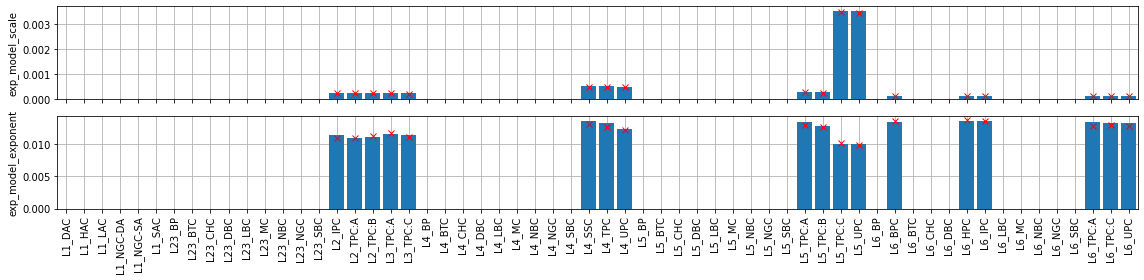

In [25]:
plt.figure(figsize=(16, 4))
for cidx, cname in enumerate(coef_names):
    plt.subplot(len(coef_names), 1, cidx + 1)
    plt.bar(range(len(mtypes)), coef_tables[cidx]['mean'])
    plt.plot(range(len(mtypes)), coefs_validation[:, cidx], 'rx')
    plt.xlim([-0.5, len(mtypes) - 0.5])
    if cidx == len(coef_names) - 1:
        plt.xticks(range(len(mtypes)), labels=mtypes, rotation=90)
    else:
        plt.xticks(range(len(mtypes)), labels=[])
    plt.grid()
    plt.gca().set_axisbelow(True)
    plt.ylabel(cname)
plt.tight_layout()
plt.show()